# Task 2: Hyperelasticity



In [2]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib


2024-12-08 19:45:51.339569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data import

In [2]:
import numpy as np
data_biaxial = np.loadtxt('../../BCC/BCC_biaxial.txt')
data_shear = np.loadtxt('../../BCC/BCC_shear.txt')
data_planar = np.loadtxt('../../BCC/BCC_planar.txt')
data_test1 = np.loadtxt('../../BCC/BCC_test1.txt')
data_test2 = np.loadtxt('../../BCC/BCC_test2.txt')
data_test3 = np.loadtxt('../../BCC/BCC_test3.txt')

def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    SE = data[:, 18] 
    return F, P, SE


F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_shear, P_shear, W_shear = process_data(data_shear)
F_planar, P_planar, W_planar = process_data(data_planar)
F_test1, P_test1, W_test1 = process_data(data_test1)
F_test2, P_test2, W_test2 = process_data(data_test2)
F_test3, P_test3, W_test3 = process_data(data_test3)

In [3]:
def compute_invariants(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    batch_size = tf.shape(F)[0]
    
    # 计算右 Cauchy-Green 张量 C
    C = tf.einsum('bij,bjk->bik', tf.transpose(F, perm=[0, 2, 1]), F)
    
    # 计算不变量 I1, I2 和 J
    I1 = tf.linalg.trace(C)  # I1: Tr(C)
    Cof_C = tf.linalg.inv(C) * tf.linalg.det(C)[:, None, None]  # Cofactor matrix
    I2 = tf.linalg.trace(Cof_C)  # I2: Tr(Cof(C))
    J = tf.linalg.det(F)  # J: det(F)
    
    # 计算 G_cub 和不变量 I7
    e = tf.eye(3, dtype=tf.float32)  # 基础向量
    G_cub = tf.einsum('ij,kl->ijkl', e, e)  # 立方对称张量 G_cub
    G_cub = tf.tile(G_cub[None, :, :, :, :], [batch_size, 1, 1, 1, 1])  # 批量化
    I7 = tf.einsum('bij,bijkl,bkl->b', C, G_cub, C)  # I7: C : G_cub : C
    
    # 计算 I11
    I11 = tf.einsum('bij,bijkl,bkl->b', Cof_C, G_cub, Cof_C)  # I11: Cof(C) : G_cub : Cof(C)
    
    return I1, I2, J, I7, I11


In [4]:
I1_data_biaxial,I2_data_biaxial,J_data_biaxial,I7_data_biaxial,I11_data_biaxial = compute_invariants(F_biaxial)
I1_data_shear,I2_data_shear,J_data_shear,I7_data_shear,I11_data_shear = compute_invariants(F_shear)
I1_data_planar,I2_data_planar,J_data_planar,I7_data_planar,I11_data_planar = compute_invariants(F_planar)

2024-11-23 22:19:55.670362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 22:19:55.910821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13634 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-11-23 22:19:56.087015: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x87bcc10


In [5]:
I_train_biaxial = np.column_stack((I1_data_biaxial,I2_data_biaxial, J_data_biaxial, -J_data_biaxial, I7_data_biaxial, I11_data_biaxial))
I_train_shear = np.column_stack((I1_data_shear,I2_data_shear, J_data_shear, -J_data_shear, I7_data_shear, I11_data_shear))
I_train_planar = np.column_stack((I1_data_planar,I2_data_planar, J_data_planar, -J_data_planar, I7_data_planar, I11_data_planar))

In [6]:
F_train = np.concatenate([F_biaxial, F_shear, F_planar], axis=0)
P_train = np.concatenate([P_biaxial, P_shear, P_planar], axis=0)
I_train = np.concatenate([I_train_biaxial, I_train_shear, I_train_planar], axis=0)
W_train = np.concatenate([W_biaxial, W_shear, W_planar], axis=0)

In [7]:
def scale_data(P_train, W_train):
    # Step 1: 计算缩放因子 a
    # 这里使用 P_train 中所有分量的最大绝对值的倒数
    max_abs_P = np.max(np.abs(P_train))
    a = 1.0 / max_abs_P

    # Step 2: 应用缩放因子到应力张量和应变能
    P_train_scaled = a * P_train
    W_train_scaled = a * W_train

    return P_train_scaled, W_train_scaled, a

P_train_scaled, W_train_scaled, a = scale_data(P_train, W_train)

In [8]:
P_train_tensor = tf.convert_to_tensor(P_train_scaled, dtype=tf.float32)
W_train_tensor = tf.convert_to_tensor(W_train_scaled, dtype=tf.float32)
I_train_tensor = tf.convert_to_tensor(I_train, dtype=tf.float32)

### Load ICNN model

In [9]:

import models_icnn as lm1

import importlib
importlib.reload(lm1)
model_icnn = lm1.main()

model_icnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 private_c_to_w (_C_to_W)    (None, 1)                 401       
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
13/13 [==============================] - 0s 2ms/step - loss: 366.1104
Epoch 2/2500
13/13 [==============================] - 0s 1ms/step - loss: 286.8074
Epoch 3/2500
13/13 [==============================] - 0s 1ms/step - loss: 210.4936
Epoch 4/2500
13/13 [==============================] - 0s 1ms/step - loss: 159.2685
Epoch 5/2500
13/13 [==============================] - 0s 1ms/step - loss: 124.3134
Epoch 6/2500
13/13 [==============================] - 0s 1ms/step - loss: 99.8130
Epoch 7/2500
13/13 [==============================] - 0s 1ms/step - loss: 82.0851
Epoch 8/2500
13/13 [==============================] - 0s 1ms/step - loss: 68.7415
Epoch 9/2500
13/13 [==============================] - 0s 1ms/step - loss: 58.7329
Epoch 10/2500
13/13 [==============================] - 0s 1ms/step - loss: 50.7311
Epoch 11/2500
13/13 [==============================] - 0s 1ms/step - loss: 44.2569
Epoch 12/2500
13/13 [==============================] - 0s 1ms/step - loss: 39.0172
Epoch 13

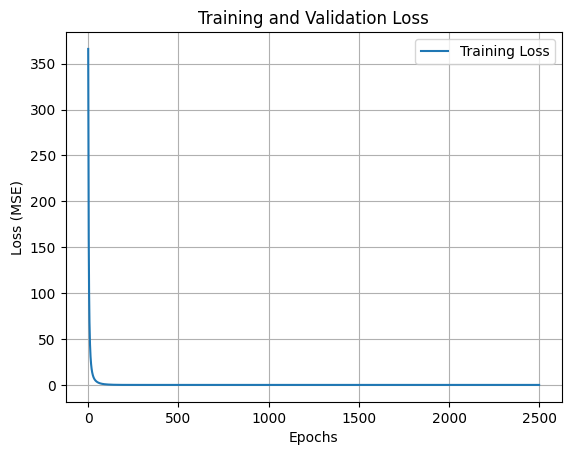

In [10]:
history = model_icnn.fit(I_train_tensor, W_train_tensor, epochs=2500)


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


In [11]:
def compute_stress_tensor(F,model):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(F)
        

        I1,I2, J, I7, I11 = compute_invariants(F)
        I_train = tf.stack([I1,I2, J, -J, I7, I11], axis=1)
        W_pred = model(I_train)

  
    P = tape.gradient(W_pred, F)
    
 
    #print("P:", P)
    
    return P

### Calibrate the model using both

In [12]:

optimizer = tf.optimizers.Adam(learning_rate=0.001)


def train_step(F, P_true, model):
    with tf.GradientTape(persistent=True) as tape:  
        tape.watch(F)
        
        
        I1,I2, J, I7, I11 = compute_invariants(F)
        I_train = tf.stack([I1,I2, J, -J, I7, I11], axis=1)
        W_pred = model(I_train)
        
        
        P_pred = tape.gradient(W_pred, F)
        
        
        loss_P = tf.reduce_mean(tf.square(P_pred - P_true))  
        loss = loss_P
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [13]:
F_train_tensor = tf.convert_to_tensor(F_train, dtype=tf.float32)

In [14]:
for epoch in range(2500):
   
    loss = train_step(F_train_tensor, P_train_tensor, model_icnn)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")

Epoch 1, Loss: 0.008550171740353107
Epoch 2, Loss: 0.006101252045482397
Epoch 3, Loss: 0.004404538311064243
Epoch 4, Loss: 0.003356724977493286
Epoch 5, Loss: 0.0028664246201515198
Epoch 6, Loss: 0.002801839727908373
Epoch 7, Loss: 0.0029996028169989586
Epoch 8, Loss: 0.0032927701249718666
Epoch 9, Loss: 0.0035475967451930046
Epoch 10, Loss: 0.0036864348221570253
Epoch 11, Loss: 0.00368711119517684
Epoch 12, Loss: 0.0035647470504045486
Epoch 13, Loss: 0.0033577405847609043
Epoch 14, Loss: 0.003114132909104228
Epoch 15, Loss: 0.0028792608063668013
Epoch 16, Loss: 0.0026887364219874144
Epoch 17, Loss: 0.002564325463026762
Epoch 18, Loss: 0.002511650789529085
Epoch 19, Loss: 0.002520516514778137
Epoch 20, Loss: 0.00256832386367023
Epoch 21, Loss: 0.0026260579470545053
Epoch 22, Loss: 0.0026673278771340847
Epoch 23, Loss: 0.0026749796234071255
Epoch 24, Loss: 0.0026439691428095102
Epoch 25, Loss: 0.002580543514341116
Epoch 26, Loss: 0.0024985841009765863
Epoch 27, Loss: 0.00241458904929459

In [15]:
P_train_pred = compute_stress_tensor(F_train,model_icnn)/a
P_test_pred = compute_stress_tensor(F_test1,model_icnn)/a

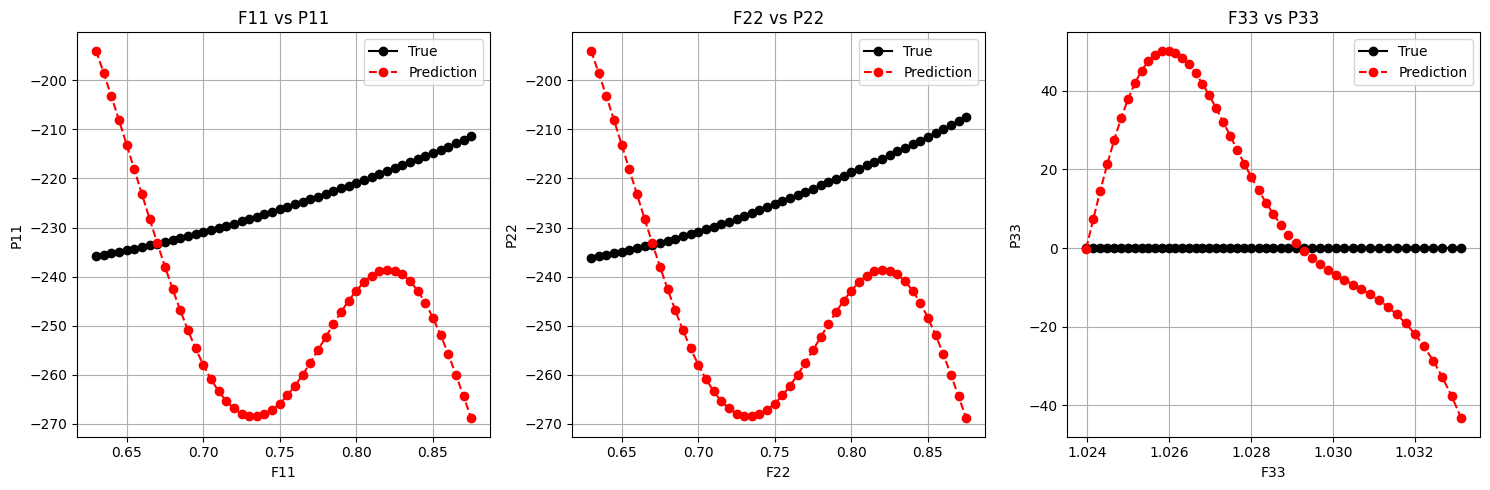

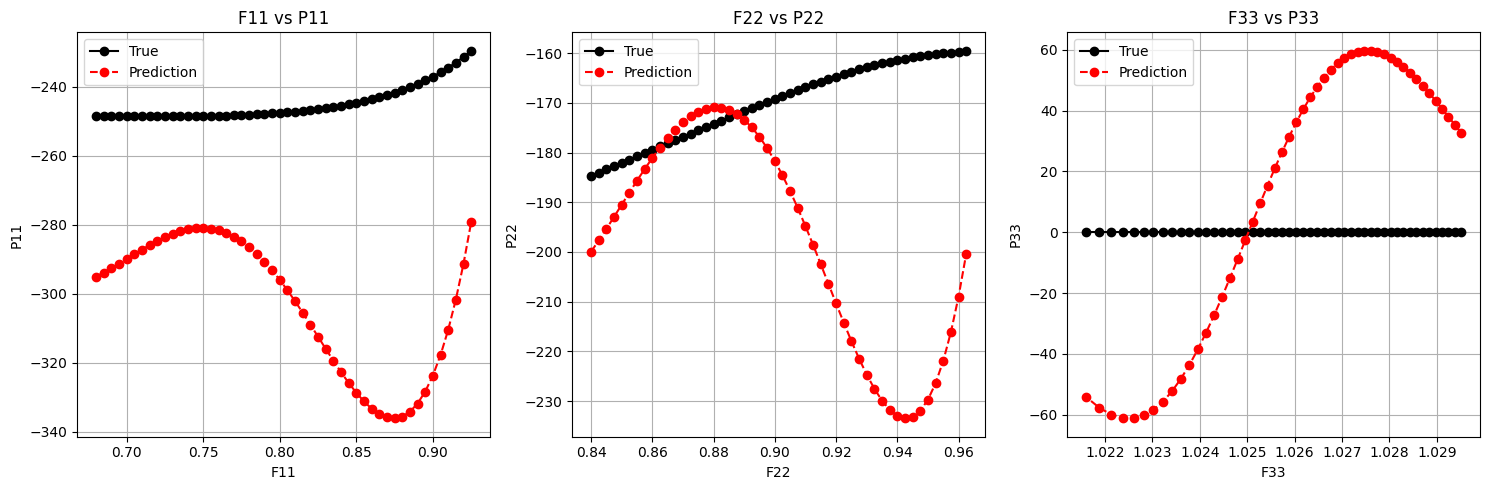

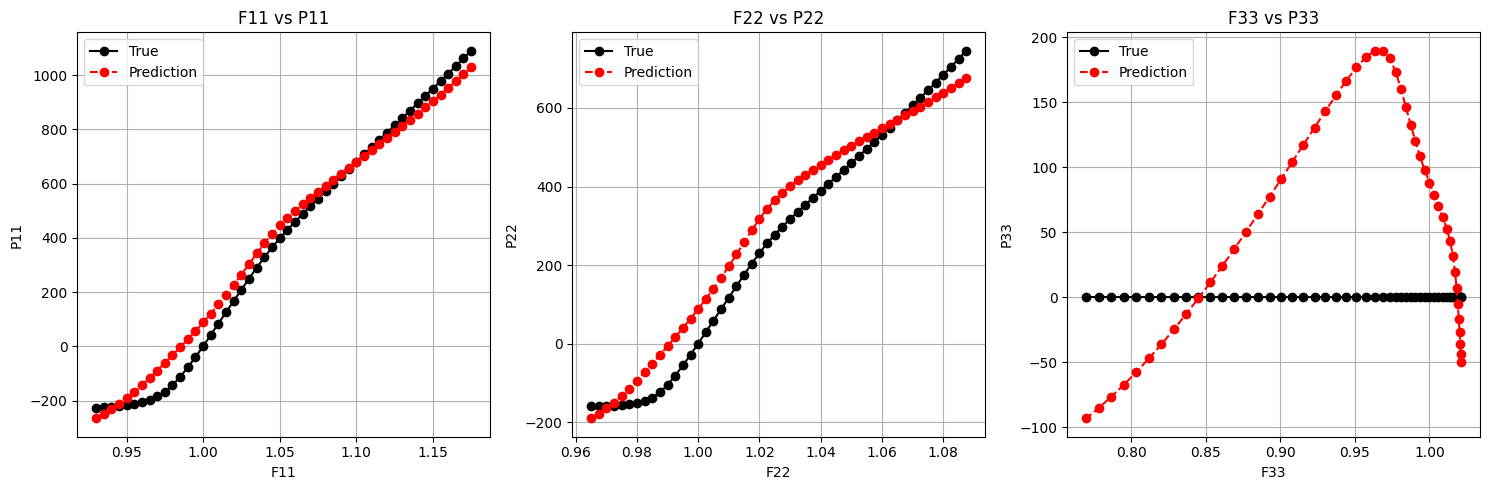

In [16]:
def plot_all_stress_vs_deformation(F_train, P_train, P_train_pred):

    F11 = F_train[:, 0, 0]  
    F22 = F_train[:, 1, 1]  
    F33 = F_train[:, 2, 2] 

    P11 = P_train[:, 0, 0]  
    P22 = P_train[:, 1, 1]  
    P33 = P_train[:, 2, 2]  

    P11_pred = P_train_pred[:, 0, 0] 
    P22_pred = P_train_pred[:, 1, 1] 
    P33_pred = P_train_pred[:, 2, 2] 


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

  
    plt.tight_layout()
    plt.show()


plot_all_stress_vs_deformation(F_train[:50], P_train[:50], P_train_pred[:50])
plot_all_stress_vs_deformation(F_test1[:50], P_test1[:50], P_test_pred[:50])
plot_all_stress_vs_deformation(F_test1[50:100], P_test1[50:100], P_test_pred[50:100])


### 5.3

In [17]:

import models_dg as lm2

import importlib
importlib.reload(lm2)
models_dg = lm2.main()

models_dg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 19)]              0         
                                                                 
 private_c_to_w_1 (_C_to_W)  (None, 1)                 609       
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [18]:
Cof_F_train = np.linalg.det(F_train)[:, None, None] * np.linalg.inv(F_train.transpose(0, 2, 1))
det_F_train = np.linalg.det(F_train)

In [26]:
F_input = np.concatenate([F_train.reshape(-1,9), Cof_F_train.reshape(-1,9), det_F_train[:, None] ], axis=1)
F_input_tensor = tf.convert_to_tensor(F_input, dtype=tf.float32)

Epoch 1/2500
13/13 [==============================] - 0s 1ms/step - loss: 11.9048
Epoch 2/2500
13/13 [==============================] - 0s 1ms/step - loss: 9.8469
Epoch 3/2500
13/13 [==============================] - 0s 1ms/step - loss: 7.5858
Epoch 4/2500
13/13 [==============================] - 0s 1ms/step - loss: 5.9911
Epoch 5/2500
13/13 [==============================] - 0s 1ms/step - loss: 4.8484
Epoch 6/2500
13/13 [==============================] - 0s 1ms/step - loss: 4.0047
Epoch 7/2500
13/13 [==============================] - 0s 1ms/step - loss: 3.3658
Epoch 8/2500
13/13 [==============================] - 0s 1ms/step - loss: 2.8639
Epoch 9/2500
13/13 [==============================] - 0s 1ms/step - loss: 2.4586
Epoch 10/2500
13/13 [==============================] - 0s 1ms/step - loss: 2.1249
Epoch 11/2500
13/13 [==============================] - 0s 1ms/step - loss: 1.8460
Epoch 12/2500
13/13 [==============================] - 0s 1ms/step - loss: 1.6100
Epoch 13/2500
13/13 [===

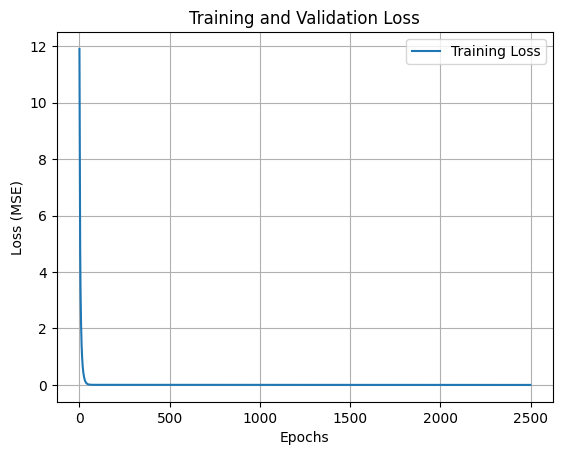

In [27]:
history = models_dg.fit(F_input_tensor, W_train_tensor, epochs=2500)


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


In [38]:
from scipy.stats import special_ortho_group
import numpy as np

def apply_rotation(F_input, num_samples=100):
    """对输入数据 F_input 应用旋转矩阵，并生成新的输入 QF_input"""
    QF_inputs = []
    for _ in range(num_samples):
        # 生成随机旋转矩阵 Q
        Q = special_ortho_group.rvs(3)

        # 提取 F, Cof(F), det(F) 的分量
        F = F_input[:, :9].reshape(-1, 3, 3)       # 提取 F 并重塑为矩阵形式
        Cof_F = F_input[:, 9:18].reshape(-1, 3, 3) # 提取 Cof(F)
        det_F = F_input[:, 18]                    # 提取 det(F)

        # 计算 QF
        QF = np.einsum('ij,bjk->bik', Q, F)  # Q * F

        # 计算 Cof(QF) 和 det(QF)
        Cof_QF = np.einsum('ij,bjk->bik', Q, Cof_F)  # Cof(QF) = Q * Cof(F)，因为 det(Q) = 1
        det_QF = det_F  # det(QF) = det(F)

        # 拼接 QF_input
        QF_input = np.concatenate(
            [QF.reshape(-1, 9), Cof_QF.reshape(-1, 9), det_QF[:, None]], axis=1
        )
        QF_inputs.append(QF_input)

    return QF_inputs


In [40]:
# 生成 QF_inputs
num_samples = 100
QF_inputs = apply_rotation(F_input, num_samples=num_samples)

# 验证旋转不变性
results = []
for QF_input in QF_inputs:
    W_original = models_dg.predict(F_input)  # 原始 W(F)
    W_rotated = models_dg.predict(QF_input) # 旋转后的 W(QF)
    results.append(np.allclose(W_original, W_rotated, atol=1e-5))  # 检查一致性

# 打印不变性结果
consistency = np.mean(results)
print(f"Consistency of invariance condition: {consistency * 100:.2f}%")


13/13 [==============================] - 0s 836us/step
Consistency of invariance condition: 0.00%


13/13 [==============================] - 0s 822us/step


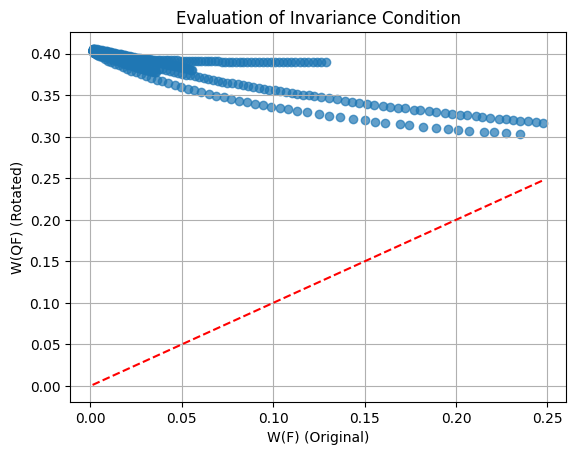

In [39]:
import matplotlib.pyplot as plt

# 选择其中一个 QF_input 的预测值进行对比
QF_input = QF_inputs[0]
W_original = models_dg.predict(F_input)
W_rotated = models_dg.predict(QF_input)

# 绘制散点图
plt.scatter(W_original, W_rotated, alpha=0.7)
plt.plot([W_original.min(), W_original.max()], [W_original.min(), W_original.max()], 'r--')  # 对角线
plt.xlabel("W(F) (Original)")
plt.ylabel("W(QF) (Rotated)")
plt.title("Evaluation of Invariance Condition")
plt.grid(True)
plt.show()


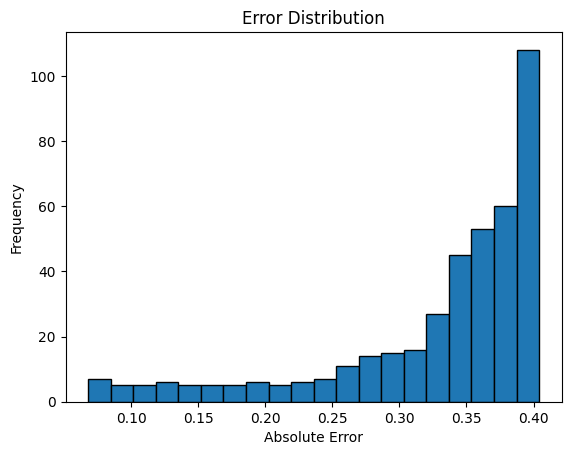

In [37]:
errors = np.abs(W_original - W_rotated)
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Error Distribution")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.show()


### 5.3

In [5]:
import numpy as np
data_biaxial = np.loadtxt('../../BCC/BCC_biaxial.txt')
data_shear = np.loadtxt('../../BCC/BCC_shear.txt')
data_planar = np.loadtxt('../../BCC/BCC_planar.txt')
data_test1 = np.loadtxt('../../BCC/BCC_test1.txt')
data_test2 = np.loadtxt('../../BCC/BCC_test2.txt')
data_test3 = np.loadtxt('../../BCC/BCC_test3.txt')

def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    SE = data[:, 18] 
    return F, P, SE


F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_shear, P_shear, W_shear = process_data(data_shear)
F_planar, P_planar, W_planar = process_data(data_planar)
F_test1, P_test1, W_test1 = process_data(data_test1)
F_test2, P_test2, W_test2 = process_data(data_test2)
F_test3, P_test3, W_test3 = process_data(data_test3)

In [6]:
def random_rotation_matrix():
    """Generate a random 3x3 rotation matrix Q in SO(3)."""
    random_vector = np.random.normal(size=(3,))
    random_vector /= np.linalg.norm(random_vector)
    theta = np.random.uniform(0, 2 * np.pi)

    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ux, uy, uz = random_vector

    Q = np.array([
        [cos_theta + ux**2 * (1 - cos_theta), ux * uy * (1 - cos_theta) - uz * sin_theta, ux * uz * (1 - cos_theta) + uy * sin_theta],
        [uy * ux * (1 - cos_theta) + uz * sin_theta, cos_theta + uy**2 * (1 - cos_theta), uy * uz * (1 - cos_theta) - ux * sin_theta],
        [uz * ux * (1 - cos_theta) - uy * sin_theta, uz * uy * (1 - cos_theta) + ux * sin_theta, cos_theta + uz**2 * (1 - cos_theta)],
    ])
    return Q


In [7]:
def augment_data(F, Cof_F, det_F, num_augmentations=10):
    """Apply random rotations to the dataset for augmentation."""
    augmented_F, augmented_Cof_F, augmented_det_F = [], [], []
    for i in range(len(F)):
        for _ in range(num_augmentations):
            Q = random_rotation_matrix()
            augmented_F.append(Q @ F[i])
            augmented_Cof_F.append(Q @ Cof_F[i])
            augmented_det_F.append(det_F[i])  # Determinant remains invariant to rotation.
    return (
        np.array(augmented_F),
        np.array(augmented_Cof_F),
        np.array(augmented_det_F),
    )


In [8]:
def objectivity_loss(model, F, Cof_F, det_F, num_rotations=10):
    """Calculate objectivity loss to ensure W(QF) = W(F)."""
    loss = 0.0
    batch_size = len(F)
    for i in range(batch_size):
        W_F = model.predict(F[i][np.newaxis])
        for _ in range(num_rotations):
            Q = random_rotation_matrix()
            QF = Q @ F[i]
            W_QF = model.predict(QF[np.newaxis])
            loss += tf.reduce_mean(tf.abs(W_F - W_QF))
    return loss / (batch_size * num_rotations)


In [ ]:
# Load your data (F, Cof_F, det_F, W)
# Assuming these are NumPy arrays
F_train, Cof_F_train, det_F_train, W_train = load_data()  # Custom function to load your data

# Data augmentation
F_aug, Cof_F_aug, det_F_aug = augment_data(F_train, Cof_F_train, det_F_train)

# Prepare input for the model
X_train = np.hstack([F_aug.reshape(len(F_aug), -1),
                     Cof_F_aug.reshape(len(Cof_F_aug), -1),
                     det_F_aug.reshape(len(det_F_aug), -1)])



# Train model with custom loss
epochs = 50
batch_size = 32
for epoch in range(epochs):
    # Main training step
    model.fit(X_train, W_train, batch_size=batch_size, epochs=1, verbose=1)
    
    # Objectivity regularization
    obj_loss = objectivity_loss(model, F_train, Cof_F_train, det_F_train)
    print(f"Epoch {epoch + 1}/{epochs}, Objectivity Loss: {obj_loss.numpy()}")
